# Study of systematic errors
To compute the spectral densities from discrete, finite points, we will use a variation of the Backus-Gilbert method (see 1903.064476).
We define the basis functions:
$$b_T(t, \omega) = \omega^2\bigl(e^{-\omega t} + e^{-\omega(T-t)}\bigr)$$
Then we define a functional to minimize:
$$A[g] = \int_{\omega_0}^{+\infty}d\omega\,\bigl(\bar{\Delta}(\omega_*, \omega) - K_{\omega_*}(\omega)\bigr)^2, \qquad \bar{\Delta}(\omega_*, \omega) = \sum_{t = 0}^{t_\mathrm(max)}g_t(\omega_*)b_T(t+1, \omega)$$
This can be rewritten in vector notation:
$$A[g] = \vec g^T A \vec g -2\vec g^T \vec f, \qquad A_{ij}=\int_{\omega_0}^{+\infty}d\omega\,b_T(i+1, \omega)b_T(j+1, \omega), \quad f_i = \int_{\omega_0}^{+\infty}d\omega\, K_{\omega_*}(\omega)b_T(i+1, \omega)$$
Its minimization brings to:
$$ \vec g = A^{-1}\vec f$$
The smeared spectral density is:
$$\rho_K(\omega_*) = \sum_{t = 0}^{t_\mathrm{t_max}} g_t(\omega_*)C(t+1)$$
Now, both the matrix $A$ and $\vec f$ can be computed analytically, the problem will be the inversion of A, and the finiteness of A, so the dependence of $\vec g$ on $t_\mathrm{max}$.

## Definitions of functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
from scipy.special import erfc
from spectral_density import *
import mpmath

## Plots of the eigenvalues as a function of $\alpha$

Let's see how alpha is a regulator for the small eigenvalues, to stabilize the algorithm.

Text(0.5, 1.0, 'Eigenvalues of the $A_{rt}$ matrix for several values of $\\alpha$')

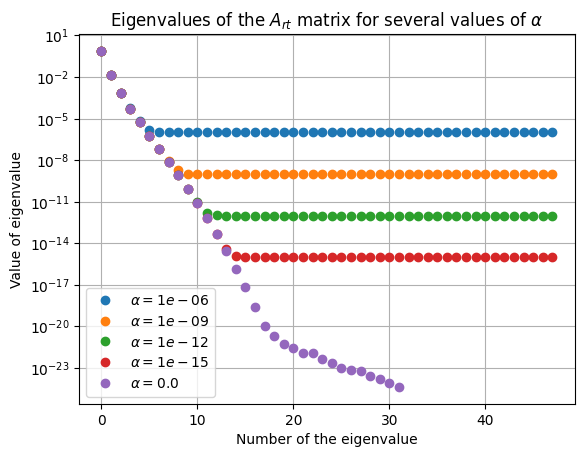

In [61]:
t_max, w0 = 48, 0.1
alpha = [1.0e-6, 1.0e-9, 1.0e-12, 1.0e-15, 0.0]
for a in alpha:
    r = Spectral_density(t_max, w0, a)
    A = r.A_alpha()
    eig, _ = np.linalg.eigh(A)
    plt.plot(range(len(eig)), np.flip(eig), "o", label=r"$\alpha = {}$".format(a))
    plt.semilogy()

plt.legend()
plt.grid()
plt.xlabel("Number of the eigenvalue")
plt.ylabel("Value of eigenvalue")
plt.title(r"Eigenvalues of the $A_{rt}$ matrix for several values of $\alpha$")

## Systematic error due to $t_\mathrm{max}$ of $\vec g$ and $\rho_K(\omega)$ 
Now we want to study the systematic error introduced by the finite $t$. I'll work fixing $\sigma = 67.5$ Mev, $\alpha = 10^{-12}$ and $\omega_* = 0.0$ for several values of $\omega_0$. To do this, I'll use as a reference $t_\mathrm{max} = 10000$, and and I'll plot $|g_{t_\mathrm{max}}/g_{10000} - 1|$ for some values of $t_\mathrm{max}$.

We'll do the same for $|\rho_{t_\mathrm{max}}/\rho_{10000} - 1|$, using several values of $\omega_*$

### Computation of correlators

In [2]:
data = open("out/vector/data/fits/direct_fit_double.txt")
lines = data.readlines()
data.close()

par = []
for l in lines:
    t = l.split()
    if int(t[0]) == 10:
        for i in range(4):
            par.append(t[1 + 2*i])
        break
par = mpmath.matrix(par)

data = open("out/vector/data/fits/cov.txt")
cov = mpmath.matrix(len(par), len(par))
for i in range(len(par)):
    for j in range(len(par)):
        cov[i, j] = mpmath.mpf(data.readline().split()[0])
data.close()

corr_func = Double_exp()

times = range(1, 48)
corr_fit = mpmath.matrix(len(times), 1)
cov_corr_fit = mpmath.matrix(len(times), len(times))
for t1 in times:
    corr_fit[t1-1] = corr_func.f(mpmath.mpf(t1), par)
    for t2 in times:
        cov_corr_fit[t1-1, t2-1] = corr_func.cov_matrix(mpmath.mpf(t1), mpmath.mpf(t2), par, cov)

par_np = []
for i in par:
    par_np.append(float(i))
    
cov_np = np.array(cov.tolist())
for i in range(len(cov_np[0, :])):
    for j in range(len(cov_np[0, :])):
        cov_np[i, j] = float(cov_np[i, j])

### Study of $\vec g$

In [64]:
alpha = 1e-12
sigma = 135/2. * 0.065 / 197.3
t_ref = 10000
t_max_list = [48, 500, 1000, 2500, 5000]
w0_list = np.array([0.0, 135/2., 135, 270, 270 * 1.5]) * 0.065/197.3
g_vect = np.zeros((len(w0_list), len(t_max_list), 48))

for i in range(len(w0_list)):
    rif = Spectral_density(t_ref, w0_list[i], alpha)
    g_rif = rif.g(0.0, sigma)
    for j in range(len(t_max_list)):
        r = Spectral_density(t_max_list[j], w0_list[i], alpha)
        g_vect[i, j, :] = np.abs(r.g(0.0, sigma)[0:48] / g_rif[0:48] - 1.0)

KeyboardInterrupt: 

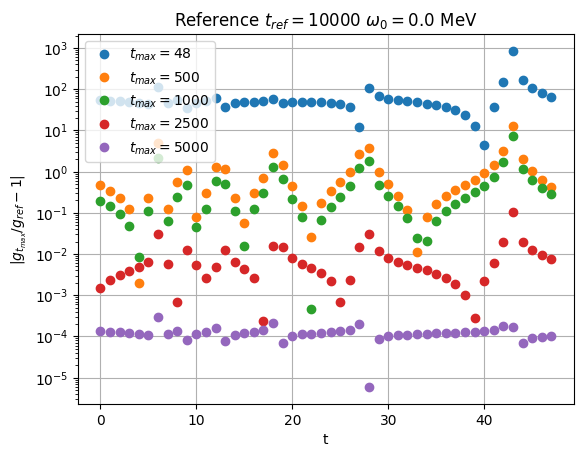

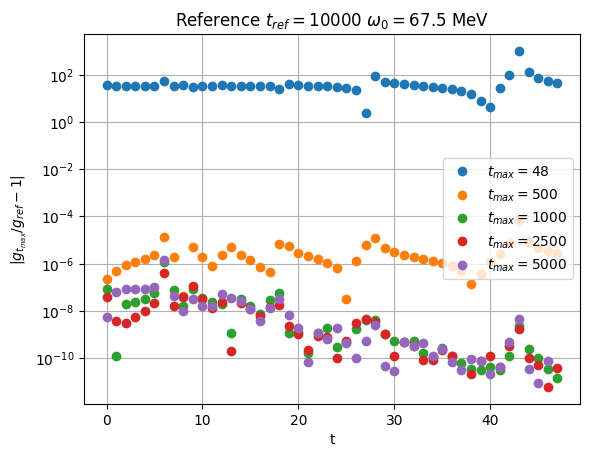

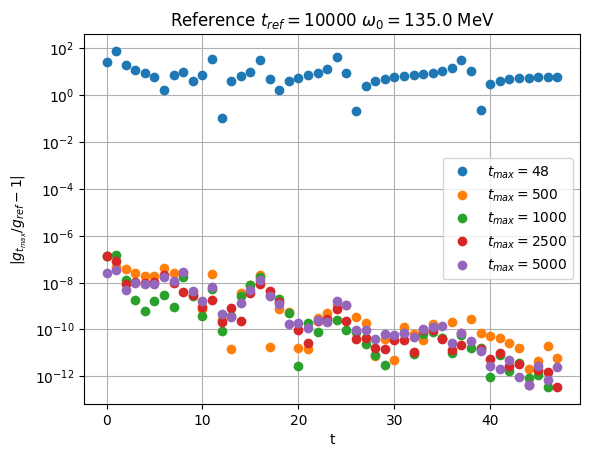

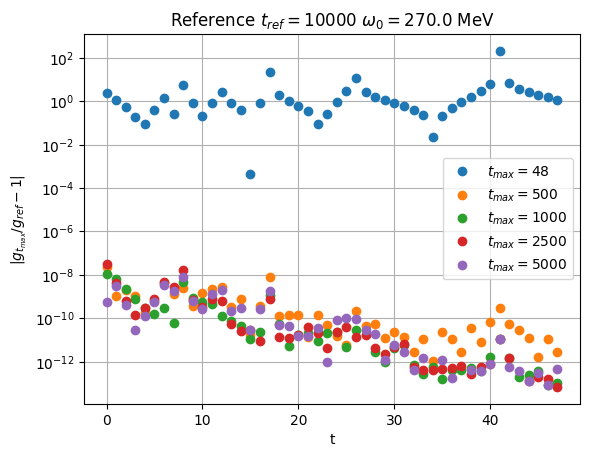

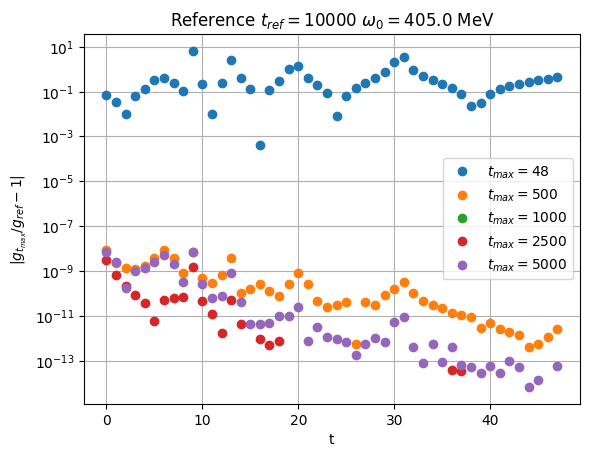

In [ ]:
w0_list = [0.0, 135/2., 135., 270., 270. * 1.5]
for i in range(len(w0_list)):
    for j in range(len(t_max_list)):
        plt.plot(range(len(g_vect[i, j, :])), g_vect[i, j, :], "o", label = r"$t_{max} = $" + "{}".format(t_max_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|g_{t_{max}} / g_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/g_coeff_w0_{}.png".format(i))
    plt.show()

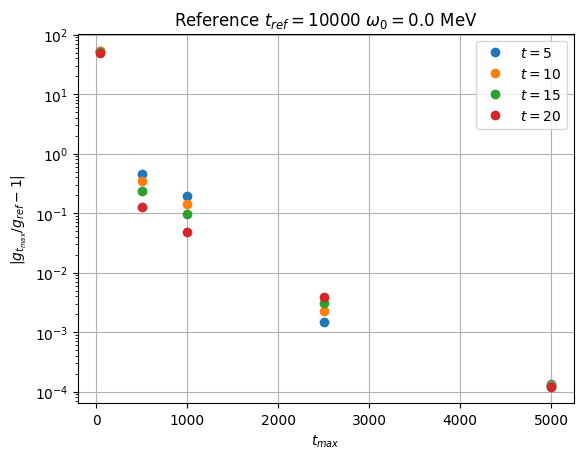

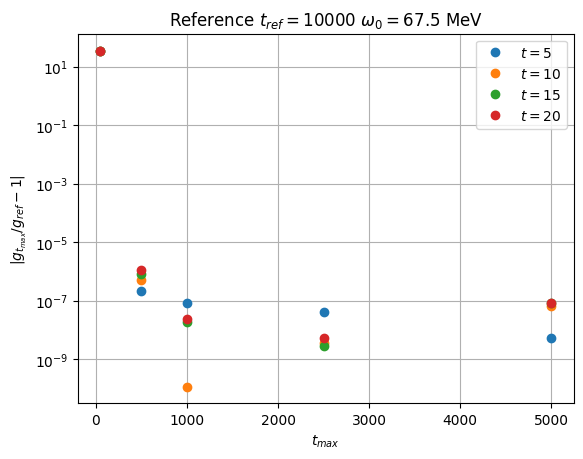

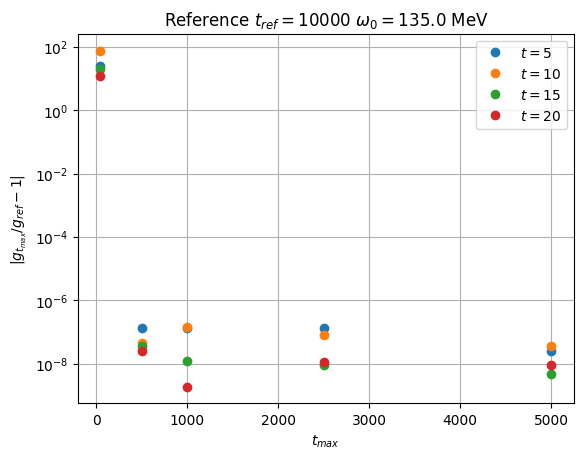

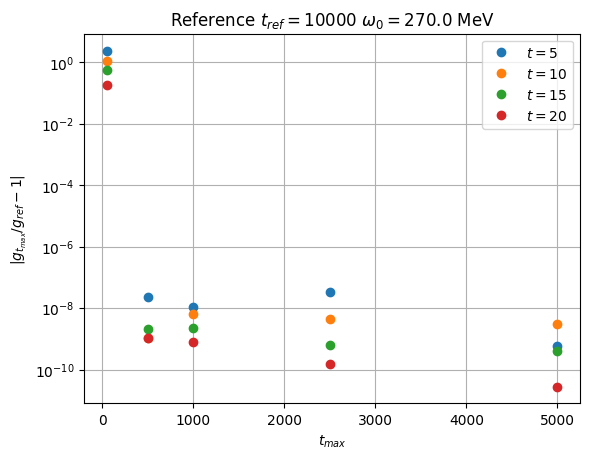

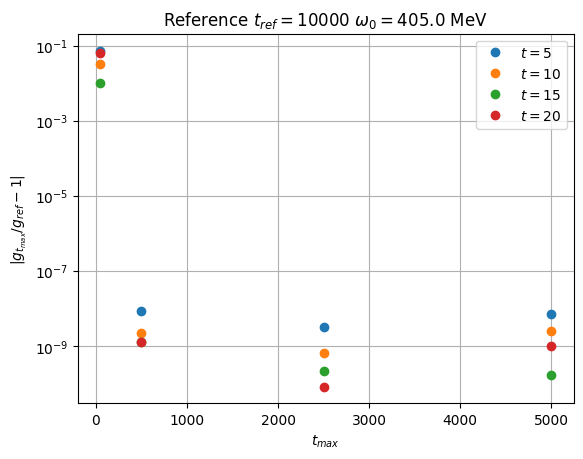

In [ ]:
w0_list = [0.0, 135/2., 135., 270., 270. * 1.5]
t_to_plot = [5, 10, 15, 20]
for i in range(len(w0_list)):
    for j in range(len(t_to_plot)):
        plt.plot(t_max_list, g_vect[i, :, j], "o", label = r"$t = $" + "{}".format(t_to_plot[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel(r"$t_{max}$")
    plt.ylabel(r"$|g_{t_{max}} / g_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/g_coeff_w0_{}_vs_tmax.png".format(i))
    plt.show()

### Study of $\rho$

In [ ]:
alpha = 1e-12
sigma = 135/2. * 0.065 / 197.3
t_ref = 10000
#t_max_list = [48, 50, 70, 90]
t_max_list = [48, 100, 200, 500, 1000]
w1_list = [0.0, 0.25, 0.5, 0.75, 1.0]
w0_list = np.array([1.5*270, 1.8*270]) * 0.065/197.3
rho = np.zeros((len(w0_list), len(t_max_list), len(w1_list)))
rho_err = np.zeros((len(w0_list), len(t_max_list), len(w1_list)))
err_ratio = np.zeros((len(w0_list), len(t_max_list), len(w1_list)))

for i in range(len(w0_list)):
    rif = Spectral_density(t_ref, w0_list[i], alpha)
    r_rif = np.zeros(0)
    r_rif_err = np.zeros(0)
    for j in range(len(w1_list)):
        r_rif = np.append(r_rif, rif.rho(w1_list[j], sigma, corr))
        r_rif_err = np.append(r_rif_err, rif.rho_err(w1_list[j], sigma, cov_corr))
    for j in range(len(t_max_list)):
        r = Spectral_density(t_max_list[j], w0_list[i], alpha)
        for k in range(len(w1_list)):
            rho[i, j, k] = np.abs(r.rho(w1_list[k], sigma, corr) / r_rif[k] - 1.0)
            rho_err[i, j, k] = np.abs(r.rho_err(w1_list[k], sigma, cov_corr) / r_rif_err[k] - 1.0)
            err_ratio[i, j, k] = np.sqrt((rho_err[i, j, k] / rho[i, j, k]) ** 2.0 + (r_rif_err[k] / r_rif[k]) ** 2.0)

/tmp/ipykernel_3881114/1198931002.py:44: RuntimeWarning: overflow encountered in exp
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_3881114/1198931002.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_3881114/1198931002.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  res = np.exp(-a*w0 - (w0-w1)**2/(2*sigma**2.0))/(2*np.sqrt(np.pi))*\
/tmp/ipykernel_3881114/1198931002.py:44: RuntimeWarning: overflow encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_3881114/3559336016.py:24: RuntimeWarning: invalid value encountered in scalar divide
  

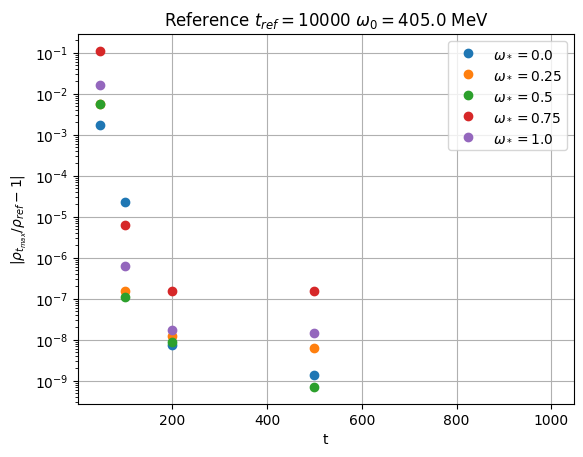

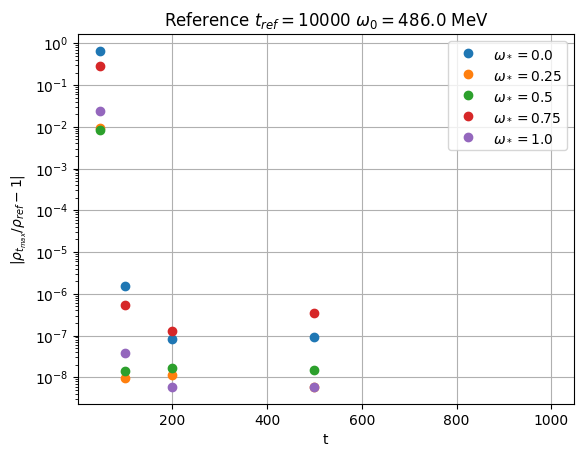

In [ ]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(len(w1_list)):
        plt.plot(t_max_list, rho[i, :, j], "o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/rho_sys_w0_{}.png".format(i+4))
    plt.show()

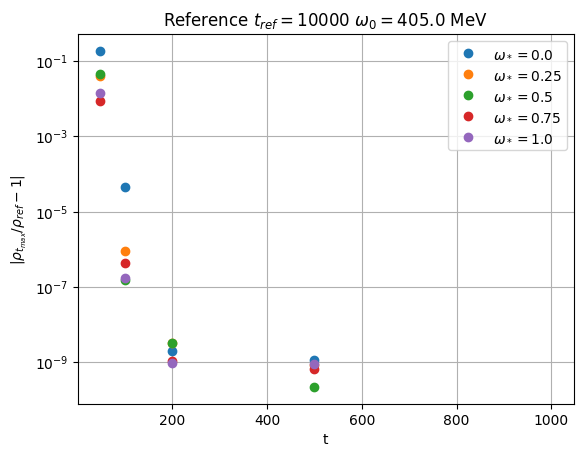

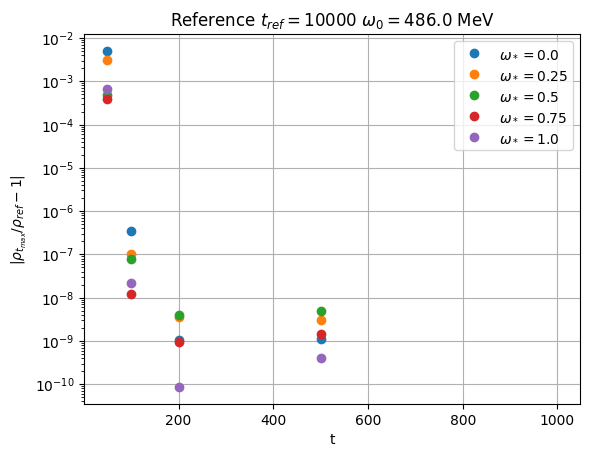

In [ ]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(len(w1_list)):
        plt.plot(t_max_list, rho_err[i, :, j], "o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/rho_err_sys_w0_{}.png".format(i+4))
    plt.show()

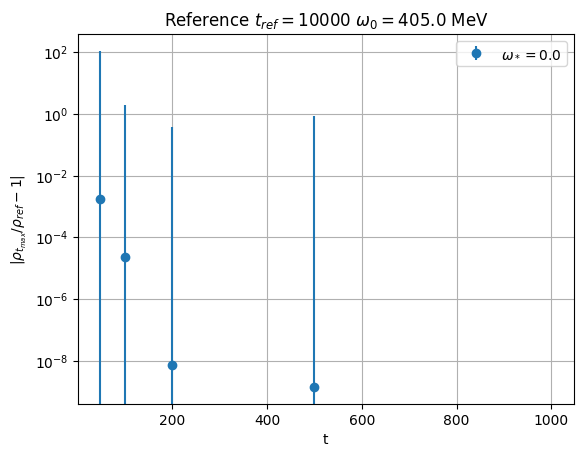

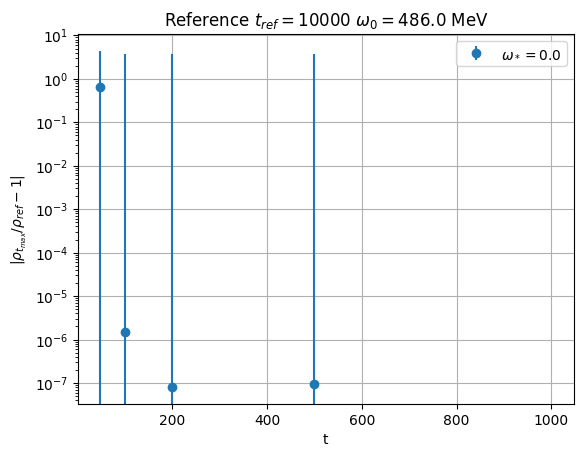

In [ ]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(1):
        plt.errorbar(t_max_list, rho[i, :, j], err_ratio[i, :, j], fmt="o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1|$")
    plt.savefig("out/vector/plots/rho/rho_sys_w0_{}_err.png".format(i+4))
    plt.show()

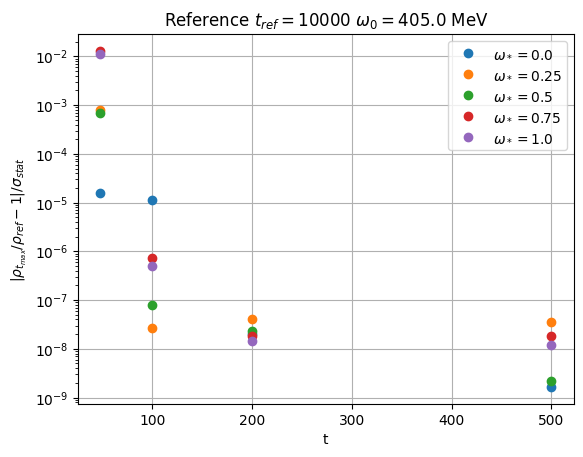

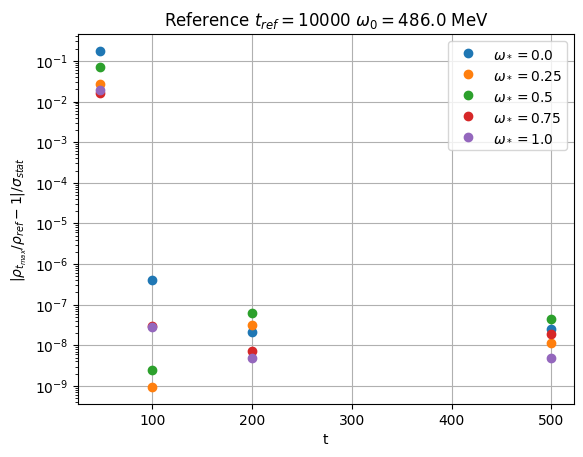

In [ ]:
w0_list = [1.5*270, 1.8*270]
for i in range(len(w0_list)):
    for j in range(len(w1_list)):
        plt.plot(t_max_list, rho[i, :, j]/err_ratio[i, :, j], "o", label = r"$\omega_* = $" + "{}".format(w1_list[j]))
    plt.title(r"Reference $t_{ref}$" + r"$= {}$".format(t_ref) + " $\omega_0 = {}$ MeV".format(w0_list[i]))
    plt.legend()
    plt.semilogy()
    plt.grid()
    plt.xlabel("t")
    plt.ylabel(r"$|\rho_{t_{max}} / \rho_{ref} - 1| / \sigma_{stat}$")
    plt.savefig("out/vector/plots/rho/rho_sys_w0_{}_ratio_err.png".format(i+4))
    plt.show()

## Plot of $\vec g$

In [25]:
w0_list = [0.0]
t_max_list = [47, 50, 100, 200]
w1_list = [3 * 270 * 0.065 / 197.3]
alpha_list = [1.0e-8]
sigma_list = np.array([270]) * 0.065 /197.3

g_vect = np.zeros((len(w0_list), len(alpha_list), len(t_max_list), len(sigma_list), len(w1_list), 48))
for w0 in range(len(w0_list)):
    for alpha in range(len(alpha_list)):   
        for t_max in range(len(t_max_list)):
            for sigma in range(len(sigma_list)):
                for w1 in range(len(w1_list)):
                    r = SDnum(t_max_list[t_max], w0_list[w0], alpha_list[alpha], w1_list[w1], sigma_list[sigma])
                    g = r.g()[0:47]
                    for i in range(47):
                        g_vect[w0, alpha, t_max, sigma, w1, i] = float(g[i])

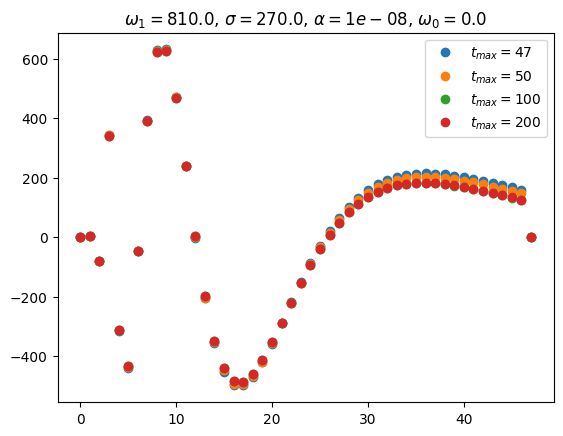

In [27]:
for w1 in range(len(w1_list)):
    for alpha in range(len(alpha_list)):    
        for sigma in range(len(sigma_list)):
            for w0 in range(len(w0_list)):
                for t_max in range(len(t_max_list)):                   
                    plt.plot(range(len(g_vect[w0, alpha, t_max, sigma, w1, :])), g_vect[w0, alpha, t_max, sigma, w1, :], "o", label = r"$t_{max} = $" + "{}".format(t_max_list[t_max]))
                plt.legend()
                plt.title(r"$\omega_1 = {}$, $\sigma = {}$, $\alpha = {}$, $\omega_0 = {}$".format(w1_list[w1] * 197.3/0.065, sigma_list[sigma]*197.3/0.065, alpha_list[alpha], w0_list[w0]))
                plt.show()

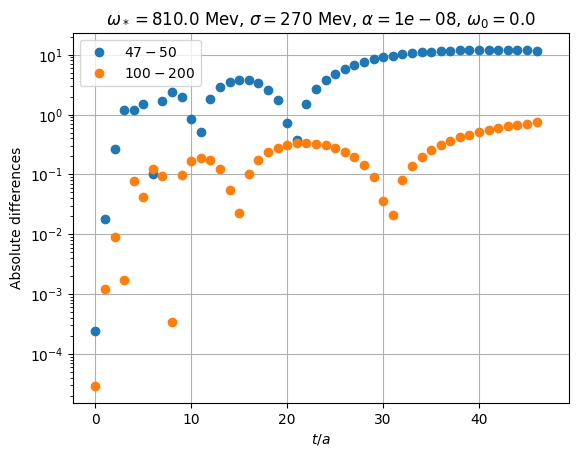

In [32]:
sigma_list = np.array([270])

for w0 in range(len(w0_list)):                  
    plt.plot(range(len(g_vect[w0, 0, t_max, 0, 0, :])), np.abs(g_vect[w0, 0, 0, 0, 0, :] - g_vect[w0, 0, 1, 0, 0, :]), "o", label = r"$47 - 50$")
    plt.plot(range(len(g_vect[w0, 0, t_max, 0, 0, :])), np.abs(g_vect[w0, 0, 2, 0, 0, :] - g_vect[w0, 0, 3, 0, 0, :]), "o", label = r"$100 - 200$")
    plt.legend()
    plt.title(r"$\omega_* = {}$ Mev, $\sigma = {}$ Mev, $\alpha = {}$, $\omega_0 = {}$".format(w1_list[0]*197.3/0.065, sigma_list[0], alpha_list[0], w0_list[w0]))
    plt.semilogy()
    plt.xlabel(r"$t/a$")
    plt.ylabel("Absolute differences")
    plt.grid()
    plt.show()

Text(0.5, 1.0, '$\\vec g$ coefficients')

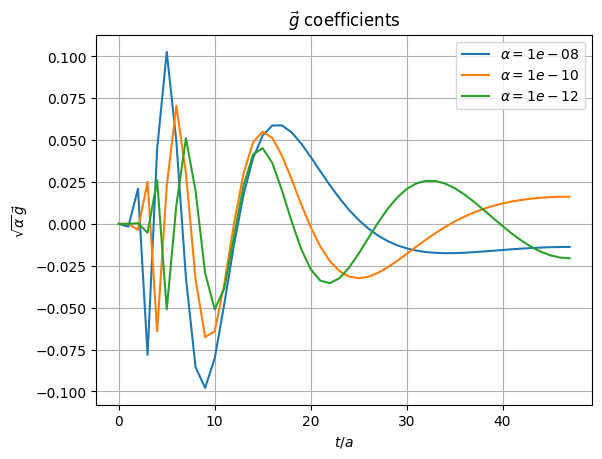

In [ ]:
for a in range(len(alpha_list)):
    plt.plot(range(len(g_vect[0, a, 0, 0, 0, :])), np.sqrt(alpha_list[a]) * g_vect[0, a, 0, 0, 0, :], label = r"$\alpha = {}$".format(alpha_list[a]), markersize = 5)
plt.grid()
plt.legend()
plt.xlabel(r"$t/a$")
plt.ylabel(r"$\sqrt{\alpha}\,\vec g$")
plt.title(r"$\vec g$ coefficients")

## Kernel reconstruction

Text(0.5, 1.0, 'Reconstruction of the kernel')

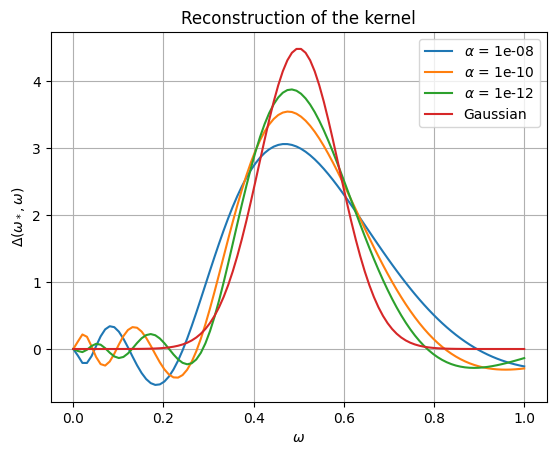

In [11]:
def basis_T(t, T, w):
    return w ** 2.0 * (np.exp(-t*w) + np.exp(-(T-t)*w))

def BG_kernel(w_star, w, t_max, lenght = 0):
    #print(t_max)
    g = r.g(w_star, 270 * 0.065 / 197.3)
    #print(g)
    sum = 0.
    if lenght == 0:
        l = len(g)
    else:
        l = lenght

    for i in range(l):
        sum += g[i] * basis_T(i+1, 2*t_max, w)
    return sum

x_grid = np.linspace(0, 1, 100)

t_max = [1.0e-8, 1.0e-10, 1.0e-12]
center = 0.5
for t in t_max:
    y = []
    r = Spectral_density(48, 0.0, t)
    for x in x_grid:
        y = np.append(y, (BG_kernel(center, x, 48)))
    plt.plot(x_grid, y, label = r"$\alpha$" + " = {}".format(t))
plt.plot(x_grid, norm(center, 270 * 0.065 / 197.3).pdf(x_grid), label = "Gaussian")
plt.legend()
plt.grid()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\Delta(\omega_*, \omega)$")
plt.title(r"Reconstruction of the kernel")


1e-06


/tmp/ipykernel_1709469/1198931002.py:44: RuntimeWarning: overflow encountered in exp
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_1709469/1198931002.py:44: RuntimeWarning: invalid value encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))
/tmp/ipykernel_1709469/1198931002.py:44: RuntimeWarning: overflow encountered in scalar multiply
  np.sqrt(np.pi) * (sigma**2. + (w1-a*sigma**2.)**2.)*np.exp((w0-w1+a*sigma**2.)**2./(2*sigma**2.))*erfc((w0-w1+a*sigma**2.)/(np.sqrt(2.)*sigma)))


1e-08
1e-10
1e-12
1e-14
1e-16


Text(0, 0.5, '$|\\Delta_{50}(\\omega_*, \\omega) - \\Delta_{5000}(\\omega_*, \\omega)|$')

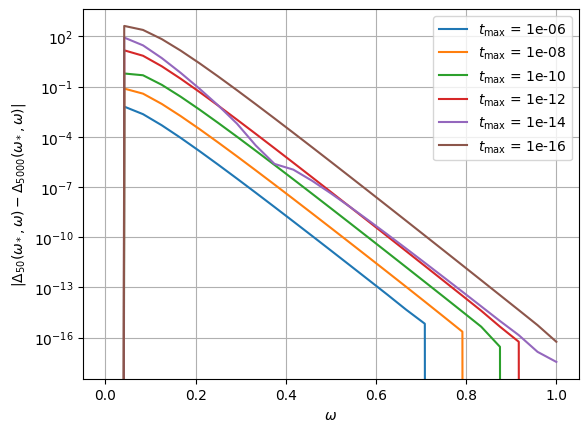

In [4]:
x_grid = np.linspace(0, 1, 25)

t_max = [1.0e-6, 1.0e-8, 1.0e-10, 1.0e-12, 1.0e-14, 1.0e-16]
center = 0.5
for t in t_max:
    print(t)
    y = []
    r = Spectral_density(5000, 0.0, t)
    for x in x_grid:
        y = np.append(y, np.abs(BG_kernel(center, x, 5000) - BG_kernel(center, x, 5000, 50)))
    plt.plot(x_grid, y, label = r"$t_\mathrm{max}$" + " = {}".format(t))
#plt.plot(x_grid, norm(center, 270 * 0.065 / 197.3).pdf(x_grid), label = "Gaussian")
plt.legend()
plt.semilogy()
plt.grid()
plt.xlabel(r"$\omega$")
plt.ylabel(r"$|\Delta_{50}(\omega_*, \omega) - \Delta_{5000}(\omega_*, \omega)|$")

In [ ]:
x_grid = np.linspace(0, 1, 101)

t_max = [1.0e-12]
center = 0.5
for t in t_max:
    y = []
    y_t = []
    r = Spectral_density(5000, 0.0, t)
    for x in x_grid:
        print(x)
        y = np.append(y, BG_kernel(center, x, 5000))
        y_t = np.append(y_t, BG_kernel(center, x, 5000, 50))
    plt.plot(x_grid, y, label = r"$t_\mathrm{max}$" + " = {}".format(t))
    plt.plot(x_grid, y_t, label = r"$t_\mathrm{max}$" + " = {}".format(t))
plt.plot(x_grid, norm(center, 270 * 0.065 / 197.3).pdf(x_grid), label = "Gaussian")
plt.legend()

Text(0.5, 1.0, '$\\alpha = 10^{-12}$, $\\omega_* = 0.5$, $\\sigma = 270$ Mev')

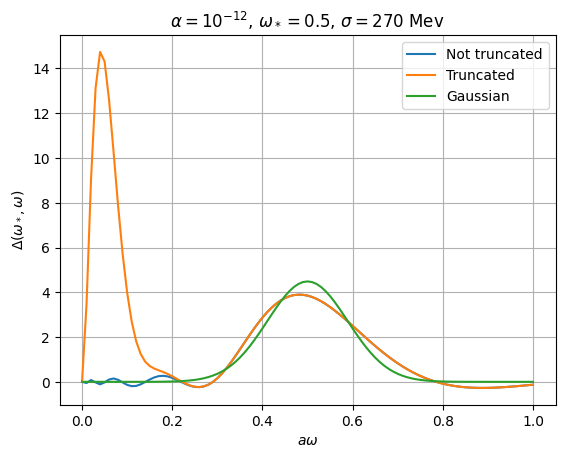

In [26]:
for t in t_max:
    plt.plot(x_grid, y, label = r"Not truncated")
    plt.plot(x_grid, y_t, label = r"Truncated")
plt.plot(x_grid, norm(center, 270 * 0.065 / 197.3).pdf(x_grid), label = "Gaussian")
plt.legend()
plt.grid()
plt.xlabel(r"$a\omega$")
plt.ylabel(r"$\Delta (\omega_*, \omega)$")
plt.title(r"$\alpha = 10^{-12}$, " + r"$\omega_* = 0.5$, " + r"$\sigma = 270$ Mev")